#### Setting

In [1]:
import sys
sys.path.append('../') # To import from parent dir

import pandas as pd
import numpy as np
import ast

import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
from datetime import datetime as dt

from util.util import *

import util.ui_stump as ui_stump
import util.skimp_uihe as ui_skimp
import util.valmod_uihe as valmod_uihe

# UI Hierarchy Based Matrix Profil Routine Discovery

## Preliminaries

Given a UI log the user has to select all context parameters in the UI log and align them to the reference model of Abb and Rehse.

### Alignment Description

In this Jupyter Notebook you achieve this by adding the context parameters to each row in the subsequent notebook-cell.<br>
Each cell is one layer of the reference model. Add the context parameters describing the level into the lists.<br>
Important: For nested UI Groups add a new group below the UI group list. Two UI groups on the same level can be added into the same list. E.g. a PPT slide and a Excel worksheet can be in the same level.<br><br>
 
Example based on SmartRPA Logs:<br>
systems = ["category"]<br>
applications = ["application"]<br>
uiGroup1 = ["workbook","browser_url","title"]<br>
uiGroup2 = ["current_worksheet"] 
uiGroup3 = ["cell_range","cell_range_number"] <br>
uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href","tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]<br>
actions = ["concept:name","eventQual"]<br>

### Alignment Hints
* Add as many UI group levels as necessary
* With each level the number of attributes outlining the level can increase, i.e., a system is described only by one parameter, e.g., system name, but an application can be at two parameters already, e.g., name and type (Edge, Browser), and an UI element can be defined by multiple parameters.
* If the UI log does not specify a level, e.g., the system or application, level the level empty in the method below.
* If you specify multiple UI group levels, they must be filled top-down. It is penalized more, if for example, the browser window is in UI group level 2 and no UI group is in level 1, which is a gap. If this is the case move the UI group up in the levels.

### SmartRPA Prep

In [2]:
# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = ["category"]
applications = ["application"]
uiGroup1 = ["workbook","browser_url","title"]
uiGroup2 = ["current_worksheet"] 
uiGroup3 = ["cell_range","cell_range_number"]
uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
             "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
actions = ["concept:name","eventQual"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]

# ---- Define the path in which all files are stored ----
folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"

UILogValidation_filename = "validation_data.csv"
variableLenValidation_filename = "var_len_validation_data.csv"
percentagData_filename = "validationDataPercentage.csv"

# ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
isSmartRPA = True
percentageLogs = []

for file in os.listdir(folder_path_smartRPA):
    if file.startswith("LenLog"):
        percentageLogs.append(file)

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

### Action Logger Prep

In [ ]:
# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = []
applications = ["targetApp"]
uiGroup1 = ["url","target.workbookName"]
uiGroup2 = ["target.sheetName"]
uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
actions = ["eventType"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]

# ---- Define the path in which all files are stored ----
folder_path_leno = "../logs/leno/"

sep = ";"
leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep)
leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv", sep=sep)
leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep)
leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv", sep=sep)

## Single Log Discovery - Single Window Size

Only change:
- Window_Size: Based on expectation of motif length
- log: based on the Log you want to process
- hierarchy_list: based on the log you selected and its context parameters
  - hierarchy_list_smartrpa or
  - hierarchy_list_leno

In [4]:
# ---- Parameter Setup ----
window_size = 30
doPrints = False

# ---- SmartRPA Example ----
log = "LenLog_1_1_10_15_5_3000.csv"
hierarchy_list = hierarchy_list_smartrpa
isSmartRPA = True

# ---- Leno Example ----
# log = "2509_extended_SR_RT_plus.csv"
# ground_truth = "2509_extended_SR_RT_plus_ground_truth.csv"
# hierarchy_list = hierarchy_list_leno
# isSmartRPA = False

Start: 2025-10-09 22:25:50.696495


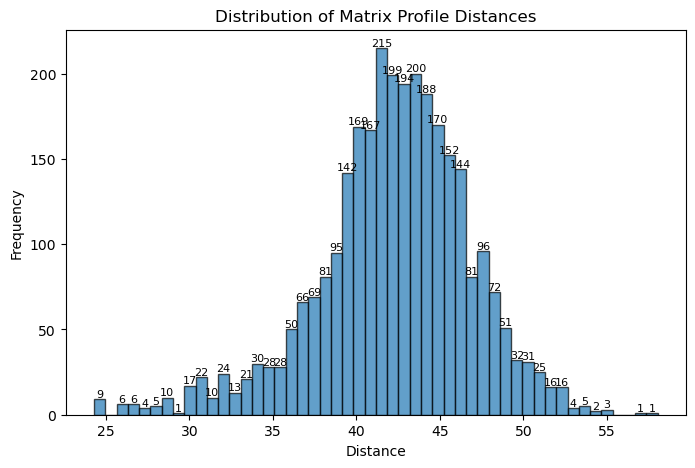

Discovered motifs: [(1794, 1492, 24.28571428571429), (1903, 1794, 24.28571428571429), (1761, 1794, 24.821269841269842), (2074, 1917, 24.871111111111116), (2473, 2567, 28.1720634920635)]
Comparison results: (   originalMotif  discoveredMotif  alignmentAccuracy
0           1505             1492           0.133333
1           1776             1761           0.000000
2           1809             1794           0.000000
3           2075             2074           0.933333
4           1918             1903           0.000000,)


In [ ]:
# ---- Processing ---- Do not change anything below this line ----
print(f"Start: {dt.now()}")

if isSmartRPA:
    sep = ","
    file = pd.read_csv(folder_path_smartRPA + log, sep=sep)
else: 
    sep = ";"
    file = pd.read_csv(folder_path_leno + log, sep=sep)

# encode into symbol ids
paths = ui_stump.build_paths_from_df(file, hierarchy_list)
if doPrints:
    print(paths[:10])
    print(f"Paths: {dt.now()}")
    print("\n")

symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))
if doPrints:
    print(symbol_of_path)
    print(levels)
    print(f"Symbols and Levels: {dt.now()}")
    print("\n")

T_ids = ui_stump.encode_series(paths, symbol_of_path)
if doPrints:
    print(T_ids[:10])
    print(f"Encoding: {dt.now()}")
    print("\n")

# build cost matrix
weights = ui_stump.hierarchy_weights(len(hierarchy_list))
if doPrints:
    print(weights)
    print(f"Weights: {dt.now()}")
    print("\n")
# C = ui_stump.build_cost_matrix(levels, weights)
# print(C)
# print(f"Cost Matrix: {dt.now()}")
# print("\n")

# run matrix profile
mp = ui_stump.stump(T_ids, levels=levels, weights=weights, m=window_size)

if doPrints:
    print(mp.P_)        # distances
    print(mp.I_)        # indices
    print(mp.left_I_)   # left neighbors
    print(mp.right_I_)  # right neighbors

def plot_matrix_profile_hist(mp, bins=50):
    """
    Plot histogram of the matrix profile values (distances).
    mp: result of ui_stump.stump (mparray object)
    """
    values = np.array(mp.P_, dtype=float)
    values = values[np.isfinite(values)]  # remove inf/nan

    # Create histogram
    plt.figure(figsize=(8, 5))
    counts, bin_edges, patches = plt.hist(values, bins=bins, edgecolor="black", alpha=0.7)
    # Add count labels above each bar
    for count, patch in zip(counts, patches):
        if count > 0:
            # Compute bar center position
            bin_center = patch.get_x() + patch.get_width() / 2
            plt.text(
                bin_center,
                count,
                f"{int(count)}",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=0
            )
    plt.title("Distribution of Matrix Profile Distances")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.show()

    return values

# Example usage:
plot_matrix_profile_hist(mp)

if isSmartRPA:
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log]
    insertSpots = comparisonVariables["motifSpots"]
    # convert every motifSpots entry from string → list[int]
    parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # flatten into a single list of ints
    insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
    insert_spots_set = set(insert_spots_flat)

    # discover motifs with your custom stump
    motifs = ui_stump.discover_motifs(mp, top_k=5, window_size=window_size)

    # compare against ground truth
    results = ui_stump.compare_motifs(motifs, insert_spots_set, window_size=window_size)

if not isSmartRPA:
    ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv")
    # extract indices and lengths
    insert_spots_set = set(ground_truth["start_index"].astype(int).tolist())
    # discover motifs with your custom stump
    motifs = ui_stump.discover_motifs(mp, top_k=25, window_size=window_size)

    # compare against ground truth (uses set of indices)
    results = ui_stump.compare_motifs(motifs, insert_spots_set, window_size=window_size)

print("Discovered motifs:", motifs)
print("Comparison results:", results[2:3])

# Single Log Disovery - SKIMP

In [59]:
maximalNoOfMatches = 25

# ---------------------------------------------------
start_time = dt.now()
print(f"Start: {start_time}")

# load your log file
if isSmartRPA:
    sep = ","
    file = pd.read_csv(folder_path_smartRPA + log, sep=sep)
else: 
    sep = ";"
    file = pd.read_csv(folder_path_leno + log, sep=sep)

# encode into symbol ids
paths = ui_stump.build_paths_from_df(file, hierarchy_list)
if doPrints:
    print(paths[:10])
    print(f"Paths: {dt.now()}")
    print("\n")

symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))
if doPrints:
    print(symbol_of_path)
    print(levels)
    print(f"Symbols and Levels: {dt.now()}")
    print("\n")

T_ids = ui_stump.encode_series(paths, symbol_of_path)
if doPrints:
    print(T_ids[:10])
    print(f"Encoding: {dt.now()}")
    print("\n")

# build cost matrix
weights = ui_stump.hierarchy_weights(len(hierarchy_list))
if doPrints:
    print(weights)
    print(f"Weights: {dt.now()}")
    print("\n")

# ---------------------------------------------------
# Run SKIMP motif discovery across a range of lengths
# L = Lower length, U = Upper length, S = Step size
res = ui_skimp.skimp_uihe(
    series_ids=T_ids,
    levels=levels,
    weights=weights,
    L=5, U=30, S=5,             # <- length range
    k=1,
    ignore_trivial=True,
    max_rows=None,              # can set e.g. 10 for anytime budget
    time_budget_s=None,         # or give a time budget
    motif_topK=maximalNoOfMatches    # how many motifs to report
)

# print("Lengths computed:", res["lengths"])
# print("Motifs discovered (i, j, m, d, roh):")
# for mot in res["motifs"]:
#     print(mot)

done_time = dt.now()
compute_time = done_time - start_time
compute_per_event = compute_time / len(T_ids) if len(T_ids) > 0 else None
print(f"Done: {done_time} in {compute_time} resulting in {compute_per_event} per event.")

if isSmartRPA:
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log]
    insertSpots = comparisonVariables["motifSpots"]
    # convert every motifSpots entry from string → list[int]
    parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # flatten into a single list of ints
    insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
    insert_spots_set = set(insert_spots_flat)

    # discover motifs with skimp result being distance and roh
    parsed = []
    for motif in res["motifs"]:
        if isinstance(motif, (list, tuple)) :
            i, j, m, d, rho = motif
            parsed.append((int(i), int(j), float(d)))

    # compare against ground truth
    results = ui_stump.compare_motifs(parsed, insert_spots_set, window_size=window_size)
    print(results)

    ground_truth_sum = comparisonVariables["numberOfOccurrancesToBeDiscovered"].iloc[0]
    true_positives = len(results)
    false_positives = maximalNoOfMatches - 10 - true_positives
    false_negatives = ground_truth_sum - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

Start: 2025-10-09 09:21:10.283960
Done: 2025-10-09 09:21:36.257796 in 0:00:25.973836 resulting in 0:00:00.008658 per event.
([1505, 1444, 1776, 1809, 2075, 124, 1918, 2847], [1492, 1444, 1766, 1794, 2074, 123, 1922, 2853],    originalMotif  discoveredMotif  alignmentAccuracy
0           1505             1492           0.133333
1           1444             1444           1.000000
2           1776             1766           0.333333
3           1809             1794           0.000000
4           2075             2074           0.933333
5            124              123           0.933333
6           1918             1922           0.733333
7           2847             2853           0.600000)


In [60]:
maximalNoOfMatches = 25

if isSmartRPA:
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log]
    insertSpots = comparisonVariables["motifSpots"]
    # convert every motifSpots entry from string → list[int]
    parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # flatten into a single list of ints
    insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
    insert_spots_set = set(insert_spots_flat)

    # discover motifs with skimp result being distance and roh
    parsed = []
    for motif in res["motifs"]:
        if isinstance(motif, (list, tuple)) :
            i, j, m, d, rho = motif
            parsed.append((int(i), int(j), float(d)))

    # compare against ground truth
    insert_overlap, motif_overlap, overlapDF = ui_stump.compare_motifs(parsed, insert_spots_set, window_size=window_size)
    print(motif_overlap)

    ground_truth_sum = comparisonVariables["numberOfOccurrancesToBeDiscovered"].iloc[0]
    true_positives = len(motif_overlap)
    false_positives = maximalNoOfMatches - 10 - true_positives
    false_negatives = ground_truth_sum - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

    # --- 3. Map results back to original SKIMP motifs ---
    good_motifs, bad_motifs = [], []
    discovered_indices = set(motif_overlap)

    for motif in res["motifs"]:
        i, j, m, d, rho = motif
        if int(i) in discovered_indices or int(j) in discovered_indices:
            good_motifs.append(motif)
        else:
            bad_motifs.append(motif)

    # --- 4. Print results ---
    print(f"\n✅ GOOD discoveries ({len(good_motifs)}):")
    for m in good_motifs:
        i, j, m_len, d, rho = m
        print(f"  Motif (i={i}, j={j}, m={m_len}, dist={d:.4f}, rho={rho:.4f})")

    print(f"\n❌ BAD discoveries ({len(bad_motifs)}):")
    for m in bad_motifs:
        i, j, m_len, d, rho = m
        print(f"  Motif (i={i}, j={j}, m={m_len}, dist={d:.4f}, rho={rho:.4f})")

[1492, 1444, 1766, 1794, 2074, 123, 1922, 2853]
Precision: 0.5333333333333333, Recall: 0.8, F1-Score: 0.64

✅ GOOD discoveries (7):
  Motif (i=1505, j=1444, m=10, dist=0.0000, rho=1.9152)
  Motif (i=1444, j=1505, m=15, dist=0.0000, rho=1.8041)
  Motif (i=1766, j=1799, m=25, dist=17.3390, rho=1.8011)
  Motif (i=2079, j=1922, m=10, dist=0.0000, rho=1.7855)
  Motif (i=1794, j=1492, m=30, dist=24.2857, rho=1.5010)
  Motif (i=2074, j=123, m=20, dist=15.4738, rho=1.4057)
  Motif (i=1511, j=2853, m=10, dist=8.4524, rho=0.2803)

❌ BAD discoveries (18):
  Motif (i=1776, j=1809, m=5, dist=0.0000, rho=1.9192)
  Motif (i=1449, j=1510, m=5, dist=0.0000, rho=1.8643)
  Motif (i=1918, j=2075, m=25, dist=21.0267, rho=1.7407)
  Motif (i=1804, j=1913, m=20, dist=10.9071, rho=1.6423)
  Motif (i=2473, j=2567, m=30, dist=28.1721, rho=1.1787)
  Motif (i=566, j=726, m=15, dist=13.4571, rho=1.1047)
  Motif (i=713, j=909, m=25, dist=27.3810, rho=0.9549)
  Motif (i=1872, j=1995, m=30, dist=30.0029, rho=0.9370)
 

# VALMOD Experiment Section

In [7]:
# load your log file
if isSmartRPA:
    sep = ","
    file = pd.read_csv(folder_path_smartRPA + log, sep=sep)
else: 
    sep = ";"
    file = pd.read_csv(folder_path_leno + log, sep=sep)

# encode into symbol ids
paths = ui_stump.build_paths_from_df(file, hierarchy_list)
symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))
T_ids = ui_stump.encode_series(paths, symbol_of_path)
weights = ui_stump.hierarchy_weights(len(hierarchy_list))

result = valmod_uihe.valmod(T_ids, levels=levels, l_min=5, l_max=10, p=3, weights=weights)
print("Top motifs:", result["motifs"][:3])

KeyboardInterrupt: 

## Experiment Execution

In [ ]:
# ---- Do not change from here ----

# ---- Initialize all variables that will be used ----

experimentColumns = ["experimentID","EncodingMethod","uiLogName","variationPercentage","percentageMotifsOverLog","motifLength","windowSize",
                     "windowSizeMatch","motifsToBeDiscovered","motifsDiscovered","numberOfOccurrancesToBeDiscovered",
                     "OccurancesDiscovered/TP","topMotifsT","DiscoveryPercentage","alignmentAccuracy","Precision","Recall","F1-Score","ExecutionTime","executionTimeEncoding","executionTimeDiscovery",
                     "motifSpots","discoveredSpots","DiscoveryLoops"]
def run_experiments(percentageLogs, window_sizes, hierarchy_list, percentageValData,
                    experimentID="EXP_UI_DIST", encoding_method="HierarchyAware"):
    experimentColumns = [
        "experimentID","EncodingMethod","uiLogName","variationPercentage","percentageMotifsOverLog",
        "motifLength","windowSize","windowSizeMatch","motifsToBeDiscovered","motifsDiscovered",
        "numberOfOccurrancesToBeDiscovered","OccurancesDiscovered/TP","topMotifsT","DiscoveryPercentage",
        "alignmentAccuracy","Precision","Recall","F1-Score","ExecutionTime",
        "executionTimeEncoding","executionTimeDistanceMeasure",
        "motifSpots","discoveredSpots","DiscoveryLoops"
    ]
    experimentResults = []

    for i, log in enumerate(percentageLogs):
        print(f"\n=== Processing log {i+1}/{len(percentageLogs)}: {log} ===")
        log_start_time = time.time()   # ⬅️ Startzeit für dieses Log
        comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log]
        
        # --- Step 1: Load log ---
        file = pd.read_csv(folder_path_smartRPA + log)
        start_encoding = time.time()

        # --- Step 2: Encode log ---
        paths = ui_stump.build_paths_from_df(file, hierarchy_list)
        symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))
        T_ids = ui_stump.encode_series(paths, symbol_of_path)
        weights = ui_stump.hierarchy_weights(len(hierarchy_list))
        C = ui_stump.build_cost_matrix(levels, weights)

        distanceMeasureCalculationTime = time.time() - start_encoding

        # --- Step 3: Ground truth motifs ---
        insertSpots = comparisonVariables["motifSpots"]
        inserted_motif_spots = extract_numbers(insertSpots.iloc[0])  # helper to flatten str→list

        new_row = {
            'EncodingMethod': encoding_method,
            'uiLogName': log,
            "variationPercentage": comparisonVariables["variationPercentage"].iloc[0],
            "motifLength": comparisonVariables["motifLength"].iloc[0],
            "percentageMotifsOverLog": comparisonVariables["percentageMotifsOverLog"].iloc[0],
            "motifsToBeDiscovered": comparisonVariables["motifsToBeDiscovered"].iloc[0],
            "motifsDiscovered": 1,
            "numberOfOccurrancesToBeDiscovered": comparisonVariables["numberOfOccurrancesToBeDiscovered"].iloc[0],
            "motifSpots": inserted_motif_spots
        }

        for j, size in enumerate(window_sizes):
            print(f"  -> Window size {size}")
            
            start_discovery = time.time()
            
            # --- Step 4: Run matrix profile with new distance ---
            mp = ui_stump.stump(T_ids,levels=levels, weights=weights, m=size, k=1)

            # --- Step 5: Incremental motif discovery loop ---
            matches_match = True
            maximalNoOfMatches = 10
            loops = 0
            insert_overlap, motif_overlap, overlapDF = [], [], pd.DataFrame()

            while matches_match:
                motifs = ui_stump.discover_motifs(mp, top_k=maximalNoOfMatches, window_size=size)
                insert_overlap, motif_overlap, overlapDF = ui_stump.compare_motifs(
                    motifs, inserted_motif_spots, window_size=size, tolerance=size//2
                )

                precision_now = len(insert_overlap) / max(1, maximalNoOfMatches)
                matches_match = precision_now >= 0.8
                maximalNoOfMatches += 10
                loops += 1

            discovery_time = time.time() - start_discovery

            # --- Step 6: Metrics ---
            ground_truth_sum = comparisonVariables["numberOfOccurrancesToBeDiscovered"].iloc[0]
            true_positives = len(insert_overlap)
            false_positives = maximalNoOfMatches - 10 - true_positives
            false_negatives = ground_truth_sum - true_positives

            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # --- Step 7: Store results ---
            row_copy = new_row.copy()
            row_copy.update({
                'experimentID': f"{i}.{j}",
                "discoveredSpots": motif_overlap,
                "OccurancesDiscovered/TP": len(insert_overlap),
                "topMotifsT": maximalNoOfMatches - 10,  # last successful t
                "windowSize": size,
                "windowSizeMatch": size - int(comparisonVariables["motifLength"].iloc[0]),
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score,
                "ExecutionTime": distanceMeasureCalculationTime + discovery_time,
                "executionTimeEncoding": distanceMeasureCalculationTime,
                "executionTimeDistanceMeasure": distanceMeasureCalculationTime,
                "DiscoveryPercentage": len(insert_overlap) /
                    comparisonVariables["numberOfOccurrancesToBeDiscovered"].iloc[0] * 100,
                "alignmentAccuracy": overlapDF['alignmentAccuracy'].mean() if not overlapDF.empty else 0,
                "DiscoveryLoops": loops
            })
            experimentResults.append(row_copy)

        # --- Ende des Log-Durchlaufs ---
        log_end_time = time.time()
        elapsed = log_end_time - log_start_time
        print(f"Finished log {log} in {elapsed:.2f} seconds")
        
    return pd.DataFrame(experimentResults, columns=experimentColumns)


percentagData_filename = "validationDataPercentage.csv"
percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)

percentageLogs = []


def get_percentage_logs_filtered(folder_path, all=True, length=5000, ascending=True):
    percentageLogs = []
    if all:
        for file in os.listdir(folder_path):
            if file.startswith("LenLog"):
                percentageLogs.append(file)
    else:
        for file in os.listdir(folder_path):
            if file.startswith("LenLog") and file.endswith(".csv"):
                try:
                    # extract the part between last '_' and '.csv'
                    number_str = file.rsplit("_", 1)[-1].replace(".csv", "")
                    number = int(number_str)
                    if number < length:
                        percentageLogs.append(file)
                except ValueError:
                    # skip files that don't have a valid integer before .csv
                    continue
    
    # sort numerically by dem Teil vor ".csv"
    def extract_number(f):
        try:
            return int(f.rsplit("_", 1)[-1].replace(".csv", ""))
        except ValueError:
            return float("inf")  # Falls kein int ermittelbar ist

    return sorted(percentageLogs, key=extract_number, reverse=not ascending)

percentageLogs = get_percentage_logs_filtered(folder_path_smartRPA, all=False)
print(f"Length of filtered percentageLogs: {len(percentageLogs)}")

df_results = run_experiments(percentageLogs, window_sizes=[5,10,15,20,25,30], hierarchy_list=hierarchy_list, percentageValData=percentageValData)
# df_results.to_excel("experiment_results_ui_hierarchy.xlsx", index=False)
df_results.to_csv("experiment_results_distanceMeasure.csv", index=False)

Length of filtered percentageLogs: 96

=== Processing log 1/96: LenLog_1_10_1_10_5_10_500.csv ===
  -> Window size 5
